# TCC

- Problema: localização de minérios
- Solução: aplicação de aprendizado de máquina com uso de dados de espectrometria e gravimetria para classificar locais com alta probabilidade de conter minérios
  - Minério de estudo: ouro

---
- Processamento:
  - Problemas: 
    - conversão de coordenadas para latitude/longitude e uso de 3 casas decimais para evitar perda de dados durante mesclagem de dados

  - Aprendizado de máquina:
    - desbalanceamento entre classes

---

Ref Github: https://github.com/lszam/mineralexp

In [94]:
import os
import sys
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
)
import shap
import folium

filterwarnings("ignore")

sys.tracebacklimit = 0

In [13]:
dir_projeto = Path(os.getcwd()).parent.absolute().parent.absolute()
data_dir = Path(dir_projeto, "Output", "tcc", "v1")
shp_dir = Path(data_dir, "shp")

## funções

In [ ]:
def utm_to_latlon(
    df: pd.DataFrame,
    x_col: str = "X",
    y_col: str = "Y",
    utm_zone: int = 22,
    southern_hemisphere: bool = True,
) -> pd.DataFrame:
    """
    Convert UTM coordinates to latitude/longitude (WGS84)

    Parameters:
    - df: DataFrame containing coordinates
    - x_col: Column name for easting (UTM X)
    - y_col: Column name for northing (UTM Y)
    - utm_zone: UTM zone number (Brazil is mostly zones 22-25)
    - southern_hemisphere: True for southern hemisphere (Brazil)

    Returns:
    DataFrame with new 'longitude' and 'latitude' columns
    """
    # Create UTM coordinate system
    utm = pyproj.Proj(proj="utm", zone=utm_zone, south=southern_hemisphere)

    # Create WGS84 coordinate system
    wgs84 = pyproj.Proj(proj="latlong", datum="WGS84")

    # Convert coordinates
    lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)

    # Add to DataFrame
    df = df.copy()
    df["longitude"] = lon
    df["latitude"] = lat

    df["longitude"] = df["longitude"].round(4)
    df["latitude"] = df["latitude"].round(4)

    return df


def convert_shapefile_to_latlon(shapefile_path: Path) -> gpd.GeoDataFrame:
    """
    Read a shapefile and convert coordinates to latitude/longitude (WGS84)

    Parameters:
    - shapefile_path: path for the shapefile

    Returns:
    GeoDataFrame
    """
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # Assuming it's in the same UTM as your other data
        gdf.crs = "+proj=utm +zone=22 +south +datum=WGS84 +units=m +no_defs"
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)
    return gdf


def criar_dataframe_base(df_merge_data: pd.DataFrame, df_mineral: pd.DataFrame) -> pd.DataFrame:
    """Mesclar dados de espectrometria, gravimetria e minério com base em coordenadas geográficas

    Args:
        df_merge_data (pd.DataFrame): dados de espectrometria e gravimetria
        df_mineral (pd.DataFrame): dados de minérios

    Returns:
        pd.DataFrame: dataframe com mesclagem de dados baseado em coordenadas geográficas
    """
    df_mineral = pd.merge(df_merge_data, df_mineral, how="outer", on=["longitude", "latitude"])
    df_mineral = df_mineral.fillna(0)
    df_mineral["ocorrencia"] = df_mineral["ocorrencia"].astype(np.int16)
    return df_mineral


def clusterizar_coordenadas_geograficas(df: pd.DataFrame, n_clusters: np.int16 = 8) -> pd.DataFrame:
    """Aplica clusterização nas coordenadas geográficas para modelo de aprendizado de máquina,
    como feature engineering

    Args:
        df (pd.DataFrame): dataframe com dados de coordenadas geográficas
        n_clusters (np.int16, optional): número de clusters. Defaults to 8.

    Returns:
        pd.DataFrame: dataframe com clusters de coordenadas
    """
    coords = df[["longitude", "latitude"]].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
    df["geo_cluster"] = kmeans.labels_
    dict_map_idx_lon = dict(zip(df.index, df["longitude"]))
    dict_map_idx_lat = dict(zip(df.index, df["latitude"]))
    df = df.drop(["longitude", "latitude"], axis=1)
    return df, dict_map_idx_lon, dict_map_idx_lat


def split_data(df: pd.DataFrame, test_size: np.float16 = 0.3) -> tuple:
    """Divide dados de treino e teste

    Args:
        df (pd.DataFrame): dataframe com dados
        test_size (np.float16, optional): tamanho dos dados de teste. Defaults to 0.3.

    Returns:
        tuple: _description_
    """
    X = df.drop(["ocorrencia"], axis=1)
    y = df["ocorrencia"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=420,
        stratify=y,  # dados desbalanceados
    )

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class balance - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

    return X_train, X_test, y_train, y_test


def pipeline_ml(
    models: dict,
    cv: StratifiedKFold,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
) -> dict:
    """Pipeline para modelos de aprendizado de máquina, realizando treinamento com validação cruzada e avaliação

    Args:
        models (dict): dicionário com modelos
        cv (StratifiedKFold): validação cruzada
        X_train (np.array): array de dados independentes de treino
        X_test (np.array): array de dados independentes de teste
        y_train (np.array): array de dados dependentes de treino
        y_test (np.array): array de dados dependentes de teste
    """
    results = {}
    for name, model in models.items():
        start_train = time.perf_counter()

        # Create pipeline (scale for logistic regression)
        if name == "Logistic Regression":
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = model

        # Cross-validation
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipe.fit(X_train, y_train)

        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {"model": pipe, "cv_mean_auc": cv_scores.mean(), "cv_std_auc": cv_scores.std()}

        print(f"{name} - CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Evaluate on test set
        if hasattr(pipe, "predict_proba"):
            evaluate_model(pipe, X_test, y_test)

    return results


def evaluate_model(model, X_test: np.array, y_test: np.array) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


def pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test):
    results = {}
    # Training and evaluation
    for name, pipeline in pipelines.items():
        print(f"\n=== Training {name} ===")

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        print(f"CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Test set evaluation
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
        print(f"Test F1: {res['test_f1']:.3f}")
        print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

## leitura e processamento

- leitura dos shapefiles com ocorrências de metais/minas

In [15]:
# ouro = gpd.read_file(Path(shp_dir, 'ocorrencias_Au.shp'))
# # cobre = gpd.read_file(Path(shp_dir, 'ocorrencias_Cu.shp'))
# ferro = gpd.read_file(Path(shp_dir, 'ocorrencias_Fe.shp'))
# # manganes = gpd.read_file(Path(shp_dir, 'ocorrencias_Mn.shp'))
# # niquel = gpd.read_file(Path(shp_dir, 'ocorrencias_Ni.shp'))
# # chumbo = gpd.read_file(Path(shp_dir, 'ocorrencias_Pb.shp'))
# # estanho = gpd.read_file(Path(shp_dir, 'ocorrencias_Sn.shp'))
# minas = gpd.read_file(Path(shp_dir, 'minas.shp'))
# estruturas = gpd.read_file(Path(shp_dir, 'estruturas_ln.shp'))

# ! leitura dos arquivos com conversão para latitude/longitude
ouro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Au.shp"))
# cobre = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Cu.shp'))
ferro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Fe.shp"))
# manganes = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Mn.shp'))
# niquel = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Ni.shp'))
# chumbo = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Pb.shp'))
# estanho = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Sn.shp'))

minas = convert_shapefile_to_latlon(Path(shp_dir, "minas.shp"))

estruturas = convert_shapefile_to_latlon(Path(shp_dir, "estruturas_ln.shp"))

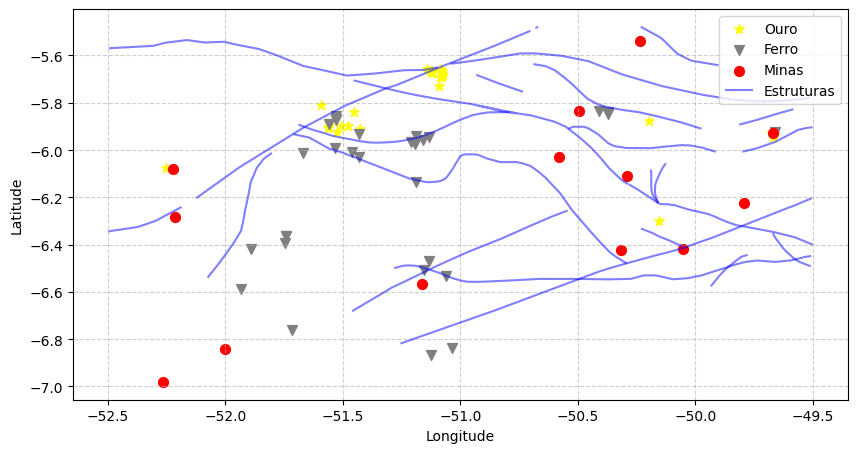

In [16]:
# https://matplotlib.org/stable/api/markers_api.html
fig, ax = plt.subplots(figsize=(10, 10))
ouro.plot(ax=ax, color="yellow", marker="*", markersize=50, label="Ouro")
ferro.plot(ax=ax, color="gray", marker="v", markersize=50, label="Ferro")
minas.plot(ax=ax, color="red", marker="o", markersize=50, label="Minas")
estruturas.plot(ax=ax, color='blue', alpha=0.5, label='Estruturas')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(visible=True, alpha=0.6, linestyle="--")
plt.legend()
plt.show()

In [17]:
df_minerio = pd.DataFrame(ouro)
df_minerio = df_minerio[["LONGITUDE", "LATITUDE"]]
df_minerio.rename(columns={"LONGITUDE": "longitude", "LATITUDE": "latitude"}, inplace=True)
df_minerio["longitude"] = df_minerio["longitude"].round(4)
df_minerio["latitude"] = df_minerio["latitude"].round(4)
df_minerio["ocorrencia"] = 1

df_minerio.head(3)

,longitude,latitude,ocorrencia
0,-51.4507,-5.8380,1
1,-52.2526,-6.0781,1
2,-51.5580,-5.8980,1


- leitura dos dados de espectrometria

  - dados:
    - Fator F: valores altos para rochas alteradas por fluidos que carregam metais
    - Kd: abundância de potássio
    - Ud: abundância de urânio

In [18]:
spec_data = pd.read_csv(
    Path(data_dir, "dados_gamaespectrometria_filtrados.csv"),
    dtype={
        "XUTM": np.float32,
        "YUTM": np.float32,
        "FatorF": np.float32,
        "Kd": np.float32,
        "Ud": np.float32,
    },
)
# spec_data.rename(columns={"XUTM": "X", "YUTM": "Y"}, inplace=True)
spec_data = utm_to_latlon(spec_data, x_col="XUTM", y_col="YUTM")
spec_data.head(3)

,XUTM,YUTM,FatorF,Kd,Ud,longitude,latitude
0,279545.71875,9101977.0,0.001366,-71.005653,-0.349341,-53.0007,-8.1192
1,279681.28125,9101978.0,0.003305,-28.235151,-0.366232,-52.9995,-8.1192
2,279816.87500,9101979.0,0.005131,-17.356588,-0.394505,-52.9982,-8.1192


- leitura dos dados de gravimetria

  - dados:
    - grav_residual190km_qht: Gravity residual at 190km (possibly Bouguer anomaly)
    - grav_residual100km: Gravity residual at 100km
    - maq_asvi: Likely some gravity-related index or processed value
    - maq_qt: Another gravity-related metric, possibly quality or quantity measure

In [19]:
grav_data = pd.read_csv(
    Path(data_dir, "dados_gravmag_filtrados_v2.csv"),
    dtype={
        "X": np.float32,
        "Y": np.float32,
        "grav_residual190km_ght": np.float32,
        "grav_residual100km": np.float32,
        "mag_asvi": np.float32,
        "mag_gt": np.float32,
    },
)
grav_data = utm_to_latlon(grav_data, x_col="X", y_col="Y")
grav_data.head(3)

,X,Y,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,longitude,latitude
0,453679.25,9102751.0,0.000501,-1.943505,67.472176,0.008145,-51.4205,-8.1169
1,454429.25,9102751.0,0.000573,-1.592606,64.604439,0.008208,-51.4136,-8.1169
2,455179.25,9102751.0,0.000563,-1.343595,62.171368,0.008150,-51.4068,-8.1169


- mesclar dfs com dados de gravimetria e espectrometria

In [20]:
df_merge_data = pd.merge(spec_data, grav_data, how="inner", on=["longitude", "latitude"]).drop(
    ["X", "Y", "XUTM", "YUTM"], axis=1
)
df_merge_data = df_merge_data[
    [
        "longitude",
        "latitude",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
    ]
]
df_merge_data.head(3)

,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt
0,-50.4878,-8.1168,0.694452,0.677858,0.362031,0.001244,7.376926,96.937653,0.010946
1,-50.0930,-8.1094,0.733680,0.439271,0.202883,0.000644,-13.605432,264.709503,0.026035
2,-49.6846,-8.1082,0.044766,-1.531327,0.273447,0.001481,-11.418680,34.700977,0.011797


- criar dataframes base para aprendizado de máquina

In [21]:
df_minerio_merge = criar_dataframe_base(df_merge_data=df_merge_data, df_mineral=df_minerio)
df_minerio_merge.head(3)

,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-53.0056,-7.9766,0.035678,0.062444,-1.777633,0.000508,6.253668,74.152176,0.007543,0
1,-53.0032,-5.7933,0.039337,0.585360,-2.711142,0.000181,-6.679170,45.226242,0.007310,0
2,-53.0032,-5.7798,0.024151,0.514961,-4.404083,0.000321,-6.968885,40.509464,0.008214,0


In [22]:
print(f"Dados de espectrometria: {spec_data.shape[0]}")
print(f"Dados de gravimetria: {grav_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Mesclagem com ouro (espec + gravim + ouro) : {df_minerio_merge.shape[0]}")

Dados de espectrometria: 7672496
Dados de gravimetria: 247298
Mesclagem de dados (espec + gravim): 1662
Mesclagem com ouro (espec + gravim + ouro) : 1688


- clusterização de coordenadas geográficas
  - n_clusters = default 8 (tutorial) -> parametrizado

In [ ]:
df_minerio_merge, dict_map_idx_lon, dict_map_idx_lat = clusterizar_coordenadas_geograficas(df=df_minerio_merge)

## aprendizado de máquina

### split treino-teste

- split padrão -> 70% treino e 30% teste

In [24]:
X_train, X_test, y_train, y_test = split_data(df=df_minerio_merge)

Train shape: (1181, 8), Test shape: (507, 8)
Class balance - Train: 1.52%, Test: 1.58%


### pipeline

In [25]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric="logloss"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = pipeline_ml(models, cv, X_train, X_test, y_train, y_test)

Tempo total de treino Random Forest: 0.07 min
Random Forest - CV AUC: 1.000 (±0.000)
ROC-AUC: 1.000
F1 Score: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00         8

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507

Tempo total de treino Logistic Regression: 0.02 min
Logistic Regression - CV AUC: 0.999 (±0.002)
ROC-AUC: 0.998
F1 Score: 0.941

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       0.89      1.00      0.94         8

    accuracy                           1.00       507
   macro avg       0.94      1.00      0.97       507
weighted avg       1.00      1.00      1.00       507

Tempo total de treino XGBoost: 0.03 min
XGBoost - CV A

In [35]:
models.keys()

dict_keys(['Random Forest', 'Logistic Regression', 'XGBoost'])

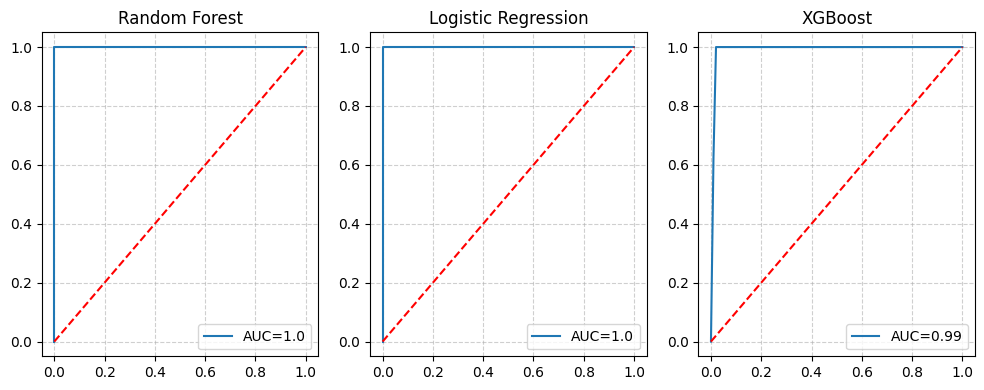

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for mdl, ax in zip(models.keys(), axs.flatten()):
    y_proba = models[mdl].predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # plot
    ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
    ax.plot([0, 1], [0, 1], "r--")
    ax.legend()
    ax.grid(visible=True, alpha=0.6, linestyle='--')
    ax.set_title(mdl)
plt.tight_layout()
plt.show()

- Problema: desbalanceamento de classes
  - As saídas apresentam 48.985 classes negativas (0) e apenas 8 positivas (1):
    - Random Forest e XGBoost apresentam um score CV AUC perfeito (1.0) porém menor AUC test (ca. 0.93)
    - Regressão logística falha completamente na classe positiva
    - os modelos estão essencialmente aprendendo a predizer a classe 0 (sem ouro) e atingindo 99.98% de acurácia

- Entendendo o problema:
  
  - Engano nas métricas de avaliação:
    - A acurácia não faz sentido aqui (99,98% prevendo sempre 0)
    - Até mesmo a AUC pode ser enganosa com desequilíbrio extremo
    - Foco na precision/recall da classe positiva

  - Comportamento do modelo:
    - Os modelos estão "desistindo" da pequena classe positiva
    - As poucas previsões positivas corretas podem ser apenas palpites de sorte

- Solução:
  - Existem diferentes soluções, porém aqui iremos aplicar uma subamostragem da classe majoritária

### pipeline undersampling

1. Random Forest

   - Desempenho Excepcional:

     - AUC (CV e Teste): 1.000 (±0.000) – Perfeito em todas as validações cruzadas e no conjunto de teste.

     - F1-Score e Precisão Média: 1.000, indicando que o modelo classificou todas as instâncias corretamente.

     - Relatório de Classificação:

       - Precisão e Recall: 100% para ambas as classes (0 e 1), mesmo com a classe 1 sendo minoritária (apenas 8 amostras).

       - Threshold Ótimo: 0.990, sugerindo que o modelo está altamente confiante em suas previsões.

   - Possíveis Problemas:

     - Overfitting ou Dados "Vazados": Um AUC de 1.000 é raro em problemas reais, especialmente com validação cruzada. Pode indicar que o modelo memorizou os dados (ex.: variáveis com informação "vazada" do target) ou que o problema é trivial (ex.: separação linear perfeita).

     - Desbalanceamento Extremo: A classe 1 tem apenas 8 amostras. O modelo pode estar superajustado a essa pequena quantidade.

---

2. Logistic Regression

   - Desempenho Irregular:

     - AUC (CV e Teste): Alto (0.992 e 0.998), mas o F1-Score é baixo (0.262), indicando que a métrica AUC pode estar mascarando problemas.

     - Relatório de Classificação:

       - Classe 0: Precisão perfeita (1.00), mas recall de 0.91 (9% de falsos negativos).

       - Classe 1: Recall perfeito (1.00), mas precisão muito baixa (0.15) – ou seja, o modelo está rotulando muitos falsos positivos para a classe minoritária.

       - Threshold Ótimo: 0.907, mais baixo que os outros modelos, o que explica o alto recall (mas baixa precisão) para a classe 1.

   - Problemas:

     - Viés para a Classe Majoritária: A regressão logística tende a priorizar a classe 0 (499 amostras), sacrificando a precisão da classe 1.

     - Métrica AUC Enganosa: Embora o AUC seja alto, o F1-Score mostra que o modelo não é útil para a classe minoritária na prática.

---

3. XGBoost

   - Desempenho Intermediário:

     - AUC (CV e Teste): 0.986 e 0.991 – alto, mas abaixo do Random Forest.

     - F1-Score: 0.615 (melhor que a regressão logística, mas pior que o Random Forest).

     - Relatório de Classificação:

       - Classe 0: Precisão e recall altos (1.00 e 0.98).

       - Classe 1: Recall perfeito (1.00), mas precisão moderada (0.44), indicando menos falsos positivos que a regressão logística.

       - Threshold Ótimo: 0.999, o mais alto entre os modelos, sugerindo confiança extrema para prever a classe 1.

   - Pontos Fortes:

     - Melhor equilíbrio entre precisão e recall para a classe minoritária que a regressão logística.

     - Menos suscetível a overfitting que o Random Forest (AUC ligeiramente menor).

In [26]:
models = {
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        penalty='l2',
        solver='lbfgs'
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
    )
}

# Create pipelines with undersampling
pipelines = {}
for name, model in models.items():
    if name == "Logistic Regression":
        # Add StandardScaler for Logistic Regression
        pipelines[name] = make_pipeline(
            RandomUnderSampler(random_state=42),
            StandardScaler(),
            model
        )
    else:
        pipelines[name] = make_pipeline(
            RandomUnderSampler(random_state=42),
            model
        )

results_unders = pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test)


=== Training Random Forest ===
CV AUC: 1.000 (±0.000)
Test ROC-AUC: 1.000
Test F1 Score: 1.000
Test Average Precision: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00         8

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507

Optimal Decision Threshold: 0.990

=== Training Logistic Regression ===
CV AUC: 0.992 (±0.011)
Test ROC-AUC: 0.998
Test F1 Score: 0.262
Test Average Precision: 0.809

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       499
           1       0.15      1.00      0.26         8

    accuracy                           0.91       507
   macro avg       0.58      0.95      0.61       507
weighted avg       0.99      0.91      0.94       507

Optima

- Pontos críticos:
  - Impacto da subamostragem:
    - melhorou dramaticamente o recall
    - reduzir dramaticamente a precisão, exceto para Random Forest
    - Random Forest é o único modelo útil no momento

- Comportamento do limiar:
  - limiares próximos a 1.0 indicam que os modelos são confidentes apenas em casos muito claros de existência de minérios, o que explica o alto recall e baixa precisão


- fazendo uso apenas do modelo Random Forest

In [74]:
best_model = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

pipeline = make_pipeline(RandomUnderSampler(random_state=42), best_model)
pipeline.fit(X_train, y_train)

# Get probabilities for class 1
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Apply threshold
y_pred_custom = (y_proba >= 0.990).astype(int)

- matriz de confusão

[[TP, FP],
[FN, TN]]

In [45]:
print(confusion_matrix(y_test, y_pred_custom))

[[499   0]
 [  0   8]]


In [46]:
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00         8

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507



- feature importance do modelo

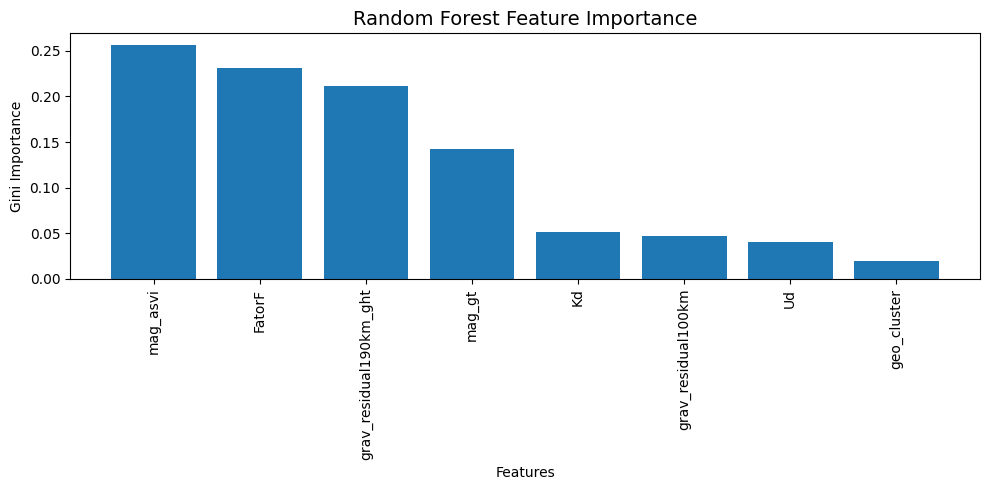

In [50]:
rf_model = pipeline.named_steps['randomforestclassifier']

importances = rf_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importance", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Gini Importance")
plt.tight_layout()
plt.show()

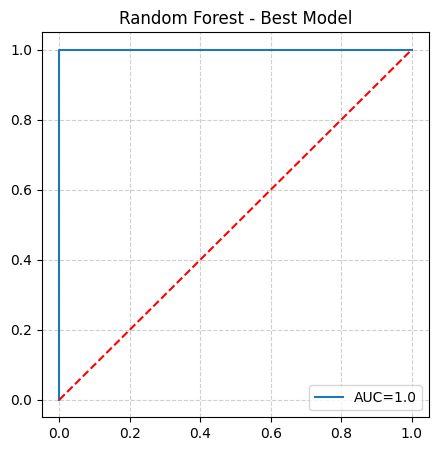

In [39]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# plot all this
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
ax.plot([0, 1], [0, 1], "r--")
ax.legend()
ax.set_title('Random Forest - Best Model')
ax.grid(visible=True, alpha=0.6, linestyle='--')
plt.show()

### SHAP

Ref: https://shap.readthedocs.io/en/latest/

Resampled data shape: (36, 8)
All SHAP values shape: (36, 8, 2)
SHAP values for class 1: (36, 8)


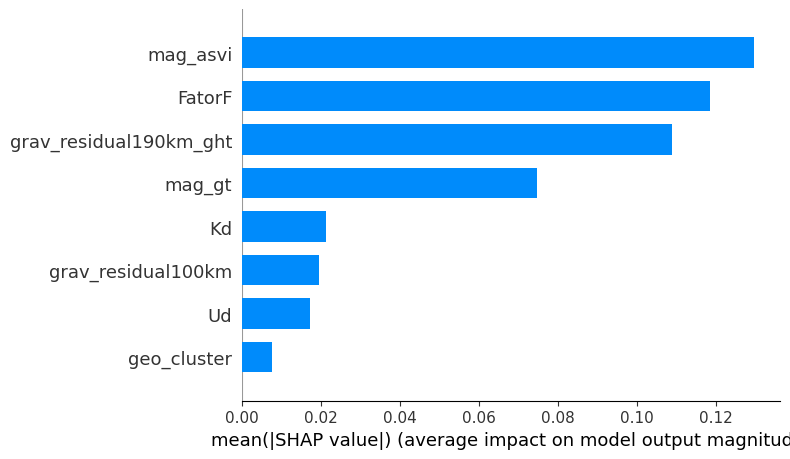

In [88]:
undersampler = pipeline.named_steps['randomundersampler']
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

model = pipeline.named_steps['randomforestclassifier']

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_resampled)

print(f"Resampled data shape: {X_resampled.shape}")
print(f"All SHAP values shape: {np.array(shap_values).shape}")
print(f"SHAP values for class 1: {shap_values[:,:,1].shape}")

shap.summary_plot(
    shap_values[:, :, 1],
    pd.DataFrame(X_resampled, columns=X_train.columns),
    feature_names=X_train.columns.tolist(),
    plot_type="bar",
)

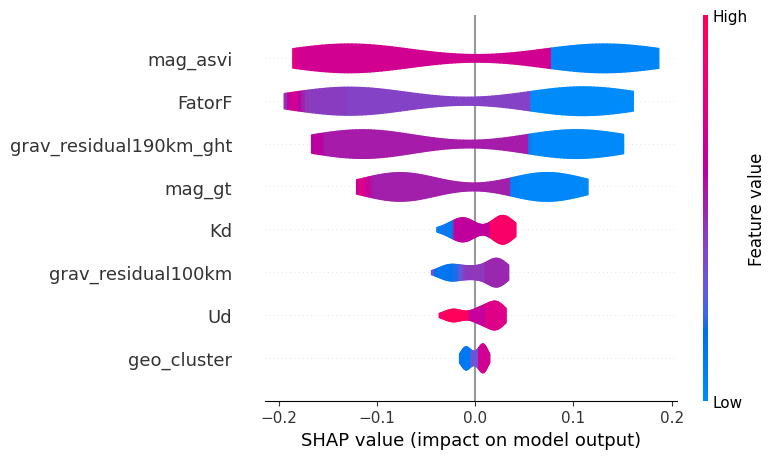

In [89]:
shap.summary_plot(
    shap_values[:, :, 1], pd.DataFrame(X_resampled, columns=X_train.columns), plot_type="violin"
)

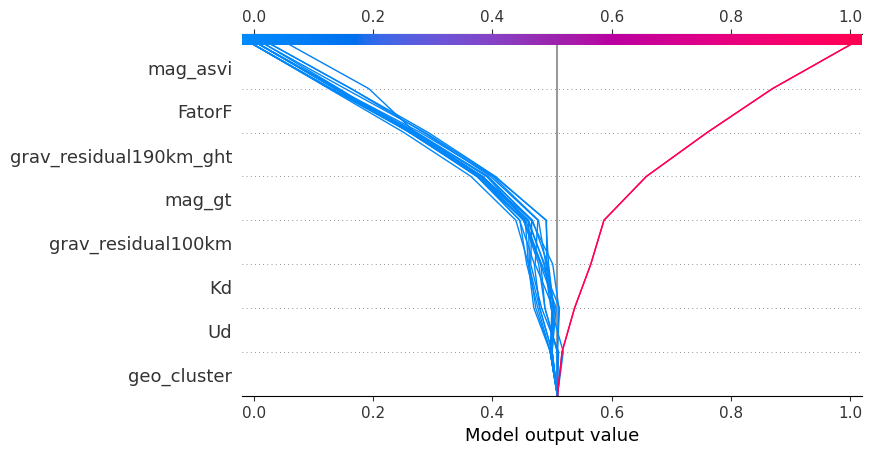

In [ ]:
shap.decision_plot(
    explainer.expected_value[1], shap_values[:, :, 1][:20], feature_names=X_train.columns.tolist()
)

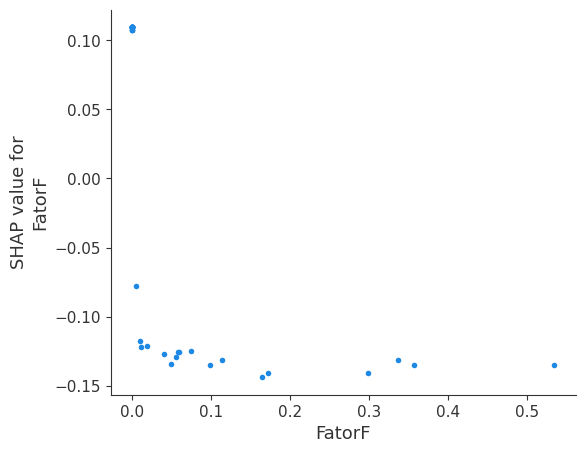

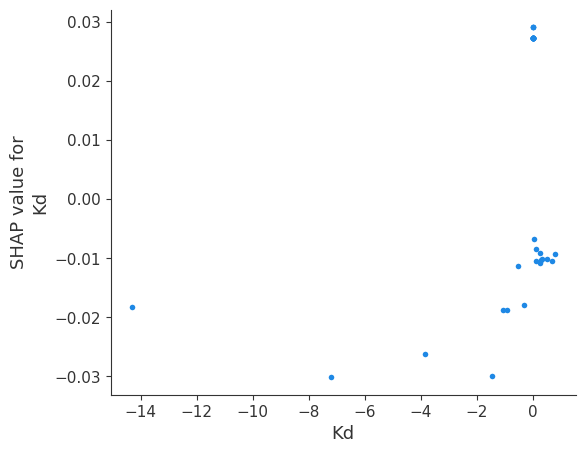

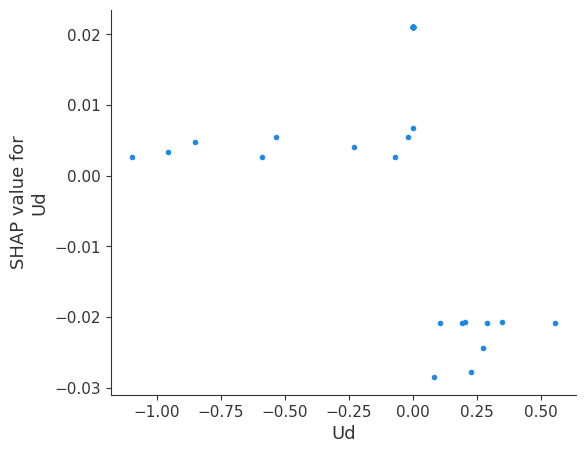

In [91]:
for feature in X_train.columns[:3]:  # Top 3 features
    shap.dependence_plot(
        feature,
        shap_values[:, :, 1],
        pd.DataFrame(X_resampled, columns=X_train.columns),
        interaction_index=None,
    )

### mapa